# **Credits**
Creator: Long Vo <br>
Date: 11/29/2022 <br>
<br>

In [87]:
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

# Load Data

In [88]:
train_ds_1 = np.loadtxt('../assets/train_dataset0-4.txt', dtype=float)
train_ds_2 = np.loadtxt('../assets/train_dataset5-9.txt', dtype=float)
test_ds_1 = np.loadtxt('../assets/test_dataset0-4.txt', dtype=float)
test_ds_2 = np.loadtxt('../assets/test_dataset5-9.txt', dtype=float)

In [89]:
def data_extract(train_data):
    data_list = list()
    label_list = list()
    for val in train_data:
        data_list.append(val[0:784])
        label_list.append(int(val[784]))
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    return data_list, label_list

np.random.shuffle(train_ds_1)
np.random.shuffle(train_ds_2)

x_train_1, y_train_1 = data_extract(train_ds_1)
x_train_2, y_train_2 = data_extract(train_ds_2)

x_test_1, y_test_1 = data_extract(test_ds_1)
x_test_2, y_test_2 = data_extract(test_ds_2)
# x_train = x_train / 255

In [90]:
y_train_2

array([7, 9, 7, ..., 8, 7, 6])

# Neural Network (Autoencoder)

In [91]:
warnings.filterwarnings('ignore')
EPOCHS = 1100
hidden_neurons = 180

In [92]:
class NeuralNetwork():
    
    def __init__(self, input_nn: int, output_nn: int, hidden_nn: list, hidden_layers: int, learning_rate=0.01, alpha=0.5, epochs=EPOCHS, high=0.75, low=0.25):
        self.input_nn = input_nn
        self.output_nn = output_nn
        self.hidden_nn = hidden_nn
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epochs = epochs
        self.high = high
        self.low = low
        self.b1 = 1
        self.y_hat = OrderedDict()
        self.w1 = np.random.randn(self.hidden_nn[0], self.input_nn) * np.sqrt(1 / (self.input_nn + self.hidden_nn[0]))
        if hidden_layers < 2:
            self.w2 = np.random.randn(self.output_nn, self.hidden_nn[0]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[0]))
            self.b2 = 1

        else:
            self.w_dict = dict()
            for i in range(self.hidden_layers):
                temp = 'w' + str(i + 2)
                if self.hidden_layers - i == 1:
                    self.w_dict[temp] = np.random.rand(self.output_nn, self.hidden_nn[i]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[i]))
                    break
                self.w_dict[temp] = np.random.rand(self.hidden_nn[i + 1], self.hidden_nn[i]) * np.sqrt(1 / (self.hidden_nn[i + 1] + self.hidden_nn[i]))
    
        
    def get_weight(self):
        if self.hidden_layers >= 2:
            return self.w1, self.w_dict
        return self.w1, self.w2
    
    
    def sigmoid(self, x): 
        return 1.0/(1.0 + np.exp(-x))


    def deri_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def forward_prop(self, input_ds):
        self.s1 = np.dot(input_ds, self.w1.T) + self.b1
        self.y_hat1 = self.sigmoid(self.s1)
        if self.hidden_layers < 2:
            self.s2 = np.dot(self.y_hat1, self.w2.T) + self.b2 # net input 
            self.y_hat2 = self.sigmoid(self.s2) # activation function for the output layer.
        else:
            self.s2 = np.dot(self.y_hat1, self.w_dict['w2'].T) + self.b # net input 
            self.y_hat['y_hat2'] = self.sigmoid(self.s2)
            for i in range(1, self.hidden_layers):
                temp_y = 'y_hat' + str(i + 1)
                temp_w = 'w' + str(i + 2)
                s = np.dot(self.y_hat[temp_y], self.w_dict[temp_w].T) + self.b
                temp_y = 'y_hat' + str(i + 2)
                self.y_hat[temp_y] = self.sigmoid(s)
                

    def get_output(self):
        if self.hidden_layers < 2:
            return self.y_hat2
        else:
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            return np.asarray(self.y_hat_value[1])            
        
        
    def backward_prop(self, x, epochs):
          
        if self.hidden_layers < 2:
            self.theta(self.y_hat2)
            self.output_errors = x - self.y_hat2
            
            self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat2)
            # print(self.d_output.shape)
            # print(self.w2.shape)
            # print(self.y_hat1.shape)
            # temp = np.dot(self.d_output, self.w2)
            # print(temp.shape)
            self.d_hidden = self.deri_sigmoid(self.y_hat1) * np.dot(self.d_output, self.w2)
            # print(self.y_hat1.shape)
            delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat1), self.d_output)             
            delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden)

            
            if (epochs > 1): 
                delta_w_2 += (self.alpha * self.pre_delta_w_2) 
                delta_w_1 += (self.alpha * self.pre_delta_w_1)
                self.w2 += delta_w_2.T 
                self.w1 += delta_w_1.T 
            
            self.pre_delta_w_2 = delta_w_2 # update of weights change
            self.pre_delta_w_1 = delta_w_1 # update of weights change
        
        else:
            w_key = ['w' + str(i + 2) for i in range(self.hidden_layers)]
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            self.y_hat_val = np.array(list(self.y_hat_val))            
            self.theta(self.y_hat_value[1])            
            self.output_errors = x - self.y_hat_value[1]
            index = len(self.y_hat_val) - 1
            
            while (index >= 0):
                self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat_val[index][1])
                self.d_hidden = self.deri_sigmoid(self.y_hat_val[index - 1][1]) * np.dot(self.d_output, self.w_dict[w_key[index]])

                delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat_val[index - 1][1]), self.d_output)
                delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden) 

                if(epochs > 1):
                    delta_w_2 += (self.alpha * self.pre_delta_w_2)
                    delta_w_1 += (self.alpha * self.pre_delta_w_1)
                    self.w_dict[index] += delta_w_2.T 
                    self.w_dict[index] += delta_w_1.T 
                
                self.pre_delta_w_2 = delta_w_2 # update of weights change
                self.pre_delta_w_1 = delta_w_1 # update of weights change
                index -= 1
                self.theta(self.y_hat_val[index-1][1])               
                self.output_errors = self.y_hat_val[index][1] - self.y_hat_val[index-1][1]
        
        
    def theta(self, y_hat): # theta for output
        for q in y_hat:
            for idx, j in enumerate(q):
                if j >= self.high:
                    q[idx] = 1.0
                elif j <= self.low:
                    q[idx] = 0.0

# Train Autoencoder

In [93]:
def error_loss(y, yhat):
    ERRORS = 0
    for idx, x in enumerate(y):
        ERRORS += (0.5 * np.sum(((x - yhat[idx])**2)))
    return ERRORS / 784

In [94]:
nn = NeuralNetwork(784, 784, [hidden_neurons], 1)
nn.forward_prop(x_train_1)
training_errors = list()

In [95]:
nn.get_output().shape

(2000, 784)

In [96]:
for i in range(EPOCHS + 1):
    nn.forward_prop(x_train_1)
    if i % 10 == 0:
        print(f'Iteration {i}:')
        temp_output = error_loss(x_train_1, nn.get_output())
        training_errors.append(temp_output)
        print(f'Error fraction: {temp_output}')
    nn.backward_prop(x_train_1, i)

Iteration 0:
Error fraction: 459.537928831078
Iteration 10:
Error fraction: 153.36591094550332
Iteration 20:
Error fraction: 137.69989270498453
Iteration 30:
Error fraction: 112.2432953653248
Iteration 40:
Error fraction: 118.00977539437847
Iteration 50:
Error fraction: 69.05545168118462
Iteration 60:
Error fraction: 56.02641561154633
Iteration 70:
Error fraction: 52.763719219248046
Iteration 80:
Error fraction: 46.17362705012336
Iteration 90:
Error fraction: 46.328038301947196
Iteration 100:
Error fraction: 40.75115976563617
Iteration 110:
Error fraction: 38.666484586130245
Iteration 120:
Error fraction: 37.73431510357293
Iteration 130:
Error fraction: 36.8902053536101
Iteration 140:
Error fraction: 36.93822365536047
Iteration 150:
Error fraction: 36.228128471923824
Iteration 160:
Error fraction: 35.79424821598102
Iteration 170:
Error fraction: 35.3852701662611
Iteration 180:
Error fraction: 34.14376340844153
Iteration 190:
Error fraction: 34.013892145827555
Iteration 200:
Error fract

### Display for testing purpose

<AxesSubplot: >

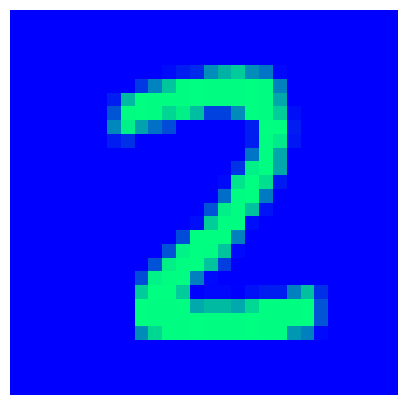

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(x_train_1[1499].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

<AxesSubplot: >

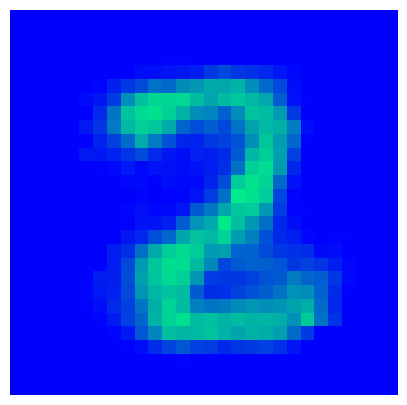

In [98]:
nn.forward_prop(x_train_1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(nn.get_output()[1499].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

# Sample Output

In [99]:
def get_random_list(limit, num):
    random_list = list()
    iteration = 0
    while iteration < limit:
        r = random.randint(0, num - 1)
        if r not in random_list:
            random_list.append(r)
            iteration += 1
    return random_list


def get_index_digit(digit, data):
    index = list()
    for i, value in enumerate(data):
        if value == digit:
            index.append(i)
    return index


def get_error_digit(y, yhat, digits):
    ERRORS = 0
    for digit in digits:
        ERRORS += (0.5 * np.sum(((y[digit] - yhat[digit])**2)))                      
    return ERRORS / 784

In [100]:
random_sample = get_random_list(8, hidden_neurons)
print(random_sample)

[14, 76, 163, 44, 9, 116, 112, 100]


### Display for testing purpose

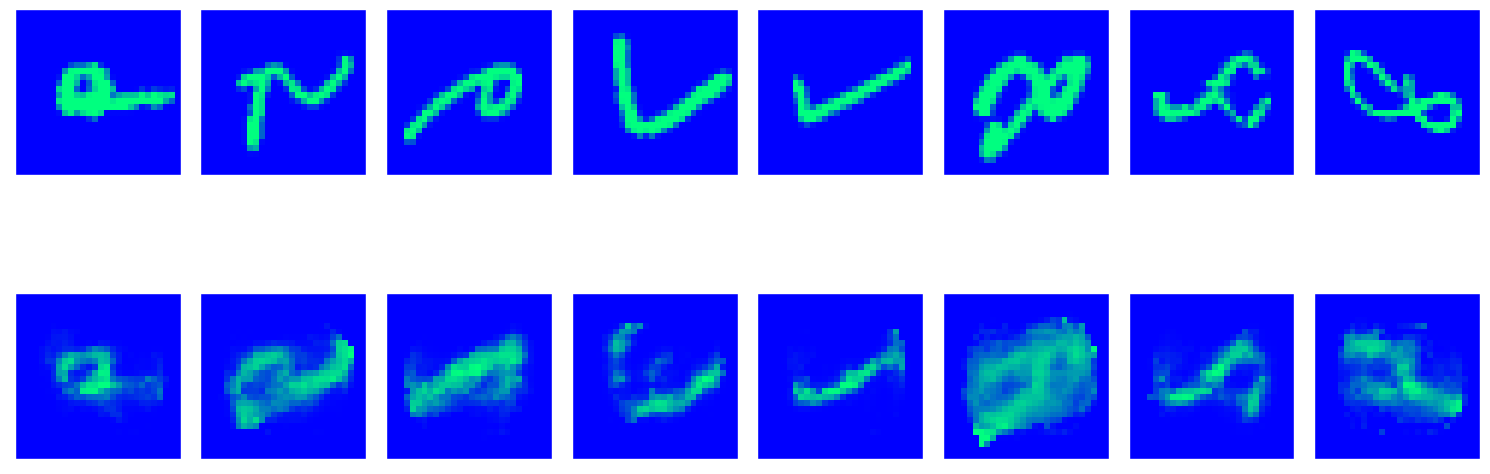

In [101]:
nn.forward_prop(x_train_2)
output_test = nn.get_output()
fig, ax = plt.subplots(2, 8, figsize=(15, 7))
plt.style.use('ggplot')
for i in range(len(random_sample)):
    ax[0, i].imshow(x_train_2[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[1, i].imshow(output_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
   
fig.tight_layout()
fig.savefig('../assets/sample_output.png')

In [102]:
random_sample = get_random_list(5, 100)
print(random_sample)

[47, 5, 39, 45, 12]


### Required sample output

In [103]:
def digit_extract(data):
    digits = dict()
    range_digits = set(data)
    for i in range_digits:
        digits[i] = get_index_digit(i, data)
    return digits

In [104]:
test_digits_1, test_digits_2 = digit_extract(y_test_1), digit_extract(y_test_2)

In [105]:
def get_random_sample(data1=list, data2=list):
    random_sample = dict()
    for i in range(10):
        if i < 5:
            random_sample[i] = random.choices(data1[i], k=5)
            
        elif i >= 5:
            # for _ in range(5):
                # random_sample.setdefault(i).append(random.choices(data2[i], k=5))
            random_sample[i] = random.choices(data2[i], k=5)
    return random_sample            

In [131]:
test_random_sample = get_random_sample(test_digits_1, test_digits_2)

In [132]:
test_random_sample

{0: [14, 11, 98, 58, 55],
 1: [171, 108, 135, 168, 118],
 2: [284, 240, 269, 268, 257],
 3: [394, 394, 381, 398, 379],
 4: [406, 474, 416, 438, 436],
 5: [41, 30, 67, 15, 31],
 6: [166, 186, 149, 120, 101],
 7: [280, 274, 238, 253, 238],
 8: [301, 312, 391, 389, 363],
 9: [438, 424, 439, 458, 437]}

In [133]:
def get_sample(test_sample):
    iteration = dict()
    for i in range(5):
        temp = list()
        for digit in test_sample:
            temp.append(test_sample[digit][i])
        iteration[i] = temp
    return iteration            

In [134]:
sample_test = get_sample(test_random_sample)

In [135]:
sample_test

{0: [14, 171, 284, 394, 406, 41, 166, 280, 301, 438],
 1: [11, 108, 240, 394, 474, 30, 186, 274, 312, 424],
 2: [98, 135, 269, 381, 416, 67, 149, 238, 391, 439],
 3: [58, 168, 268, 398, 438, 15, 120, 253, 389, 458],
 4: [55, 118, 257, 379, 436, 31, 101, 238, 363, 437]}

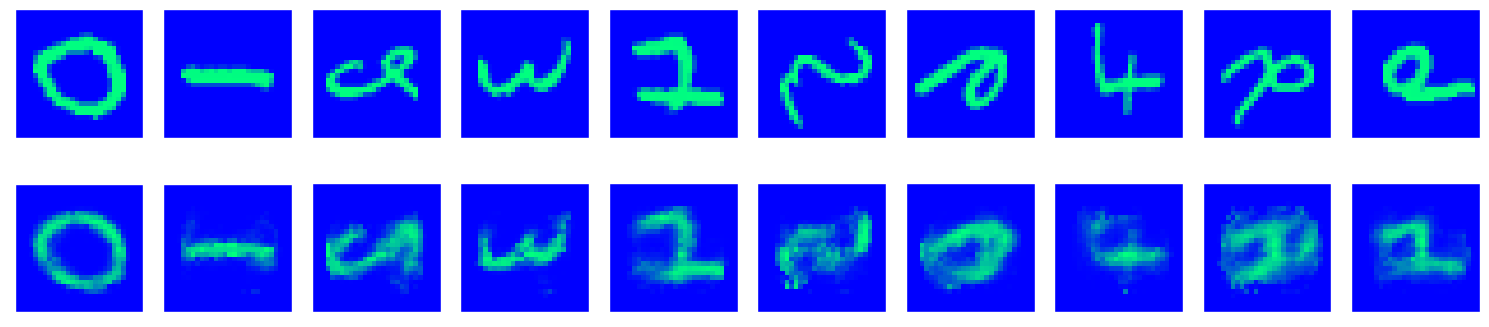

In [136]:
nn.forward_prop(x_test_1)
output_test_1 = nn.get_output()
nn.forward_prop(x_test_2)
output_test_2 = nn.get_output()
# fig, ax = plt.subplots(20, 5, figsize=(12, 14))

# for i in range(10):
#     if i < 5:
#         for j in range(5):
#             ax[i, j].imshow(x_test_1[test_random_sample[i][j]].reshape(28, 28), cmap='winter')
#             ax[i + 10, j].imshow(output_test_1[test_random_sample[i][j]].reshape(28, 28), cmap='winter')
#             ax[i, j].set_xticks([])
#             ax[i, j].set_yticks([])
#             ax[i + 10, j].set_xticks([])
#             ax[i + 10, j].set_yticks([])
#     elif i >= 5:
#         for j in range(5):
#             ax[i, j].imshow(x_test_2[test_random_sample[i][j]].reshape(28, 28), cmap='winter')
#             ax[i + 10, j].imshow(output_test_2[test_random_sample[i][j]].reshape(28, 28), cmap='winter')
#             ax[i, j].set_xticks([])
#             ax[i, j].set_yticks([])
#             ax[i + 10, j].set_xticks([])
#             ax[i + 10, j].set_yticks([])          
# fig.tight_layout()
# fig.show()

fig, ax = plt.subplots(2, 10, figsize=(15, 4))
plt.style.use('ggplot')
for i in range(len(sample_test[0])):
    if i <= 4:
        ax[0, i].imshow(x_test_1[sample_test[0][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_1[sample_test[0][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
    elif i > 4:
        ax[0, i].imshow(x_test_2[sample_test[0][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_2[sample_test[0][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
fig.tight_layout()

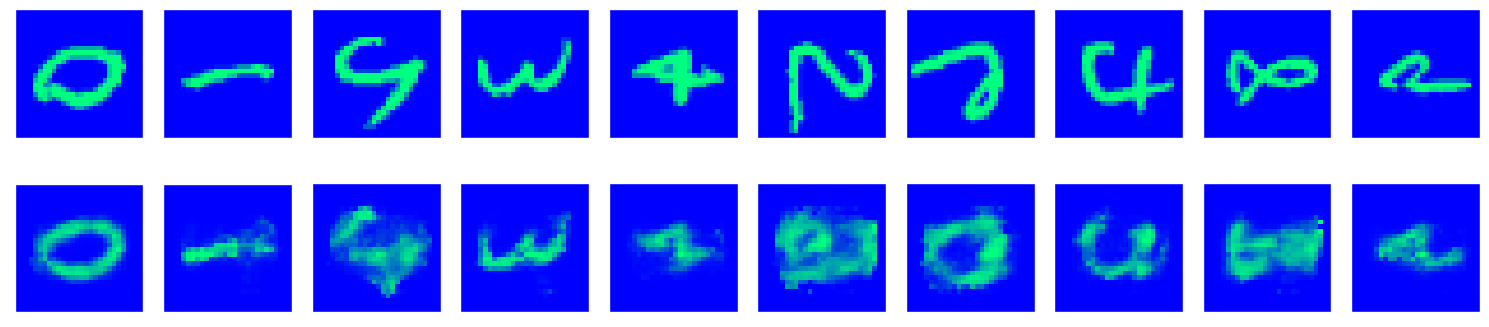

In [137]:
fig, ax = plt.subplots(2, 10, figsize=(15, 4))
plt.style.use('ggplot')
for i in range(len(sample_test[1])):
    if i <= 4:
        ax[0, i].imshow(x_test_1[sample_test[1][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_1[sample_test[1][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
    elif i > 4:
        ax[0, i].imshow(x_test_2[sample_test[1][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_2[sample_test[1][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
fig.tight_layout()

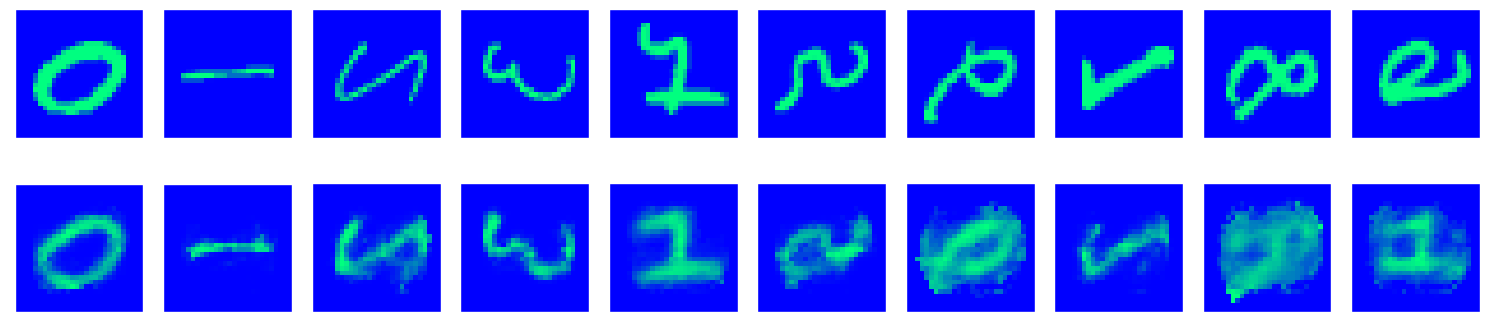

In [138]:
fig, ax = plt.subplots(2, 10, figsize=(15, 4))
plt.style.use('ggplot')
for i in range(len(sample_test[2])):
    if i <= 4:
        ax[0, i].imshow(x_test_1[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_1[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
    elif i > 4:
        ax[0, i].imshow(x_test_2[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_2[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
fig.tight_layout()

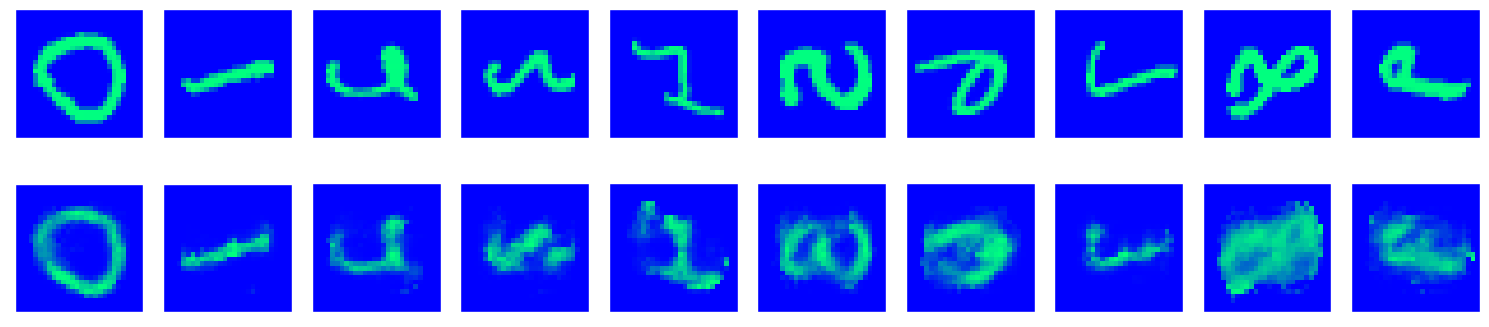

In [139]:
fig, ax = plt.subplots(2, 10, figsize=(15, 4))
plt.style.use('ggplot')
for i in range(len(sample_test[3])):
    if i <= 4:
        ax[0, i].imshow(x_test_1[sample_test[3][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_1[sample_test[3][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
    elif i > 4:
        ax[0, i].imshow(x_test_2[sample_test[3][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_2[sample_test[3][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
fig.tight_layout()

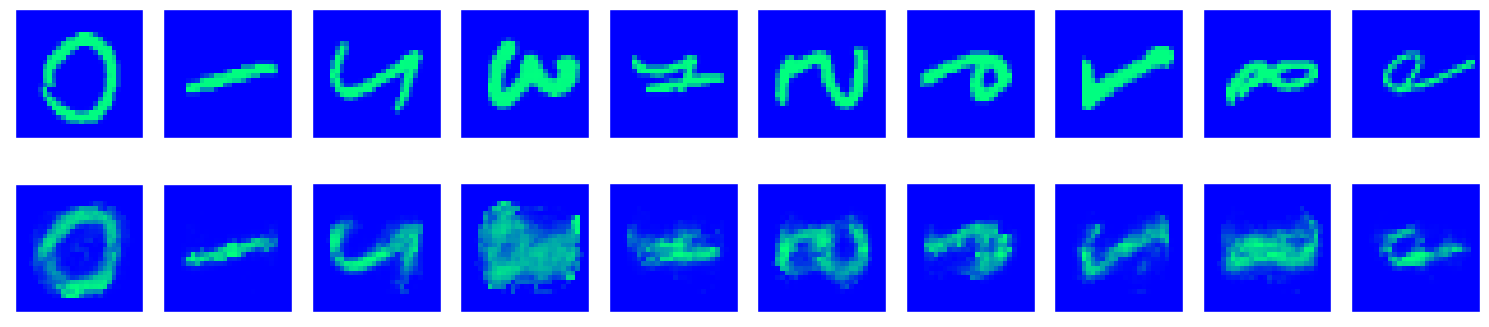

In [140]:
fig, ax = plt.subplots(2, 10, figsize=(15, 4))
plt.style.use('ggplot')
for i in range(len(sample_test[4])):
    if i <= 4:
        ax[0, i].imshow(x_test_1[sample_test[4][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_1[sample_test[4][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
    elif i > 4:
        ax[0, i].imshow(x_test_2[sample_test[4][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_2[sample_test[4][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
fig.tight_layout()

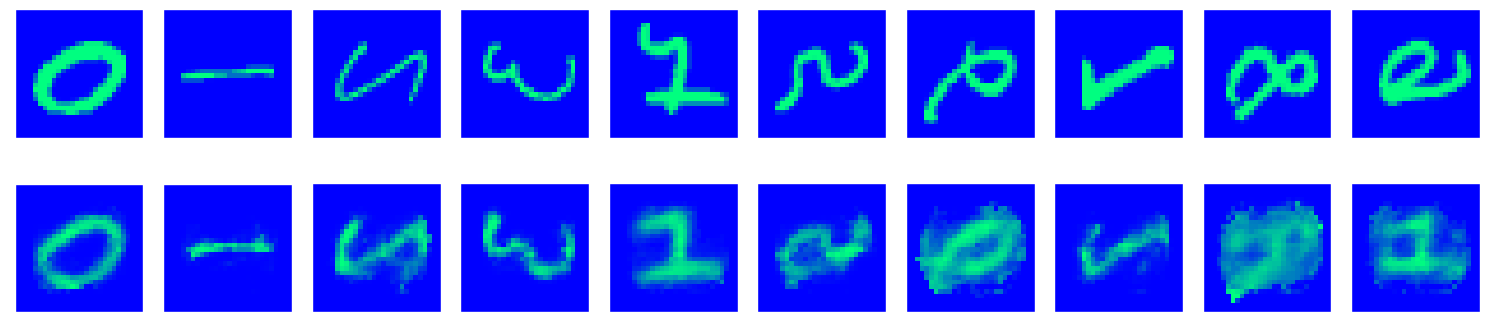

In [141]:
fig, ax = plt.subplots(2, 10, figsize=(15, 4))
plt.style.use('ggplot')
for i in range(len(sample_test[2])):
    if i <= 4:
        ax[0, i].imshow(x_test_1[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_1[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
    elif i > 4:
        ax[0, i].imshow(x_test_2[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[1, i].imshow(output_test_2[sample_test[2][i]].reshape(28, 28), cmap='winter')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
fig.tight_layout()

# Results:

In [142]:
def get_dataset_error(x, x_out, digits):
    errors = dict()
    range_digit = set(digits)
    for i in range_digit:
        errors[i] = get_error_digit(x, x_out, digits[i])
    return errors

### Final result:

In [143]:
train_digits_1, train_digits_2 = digit_extract(y_train_1), digit_extract(y_train_2)

In [144]:
nn.forward_prop(x_train_1)
train_output_1 = nn.get_output()
nn.forward_prop(x_train_2)
train_output_2 = nn.get_output()

nn.forward_prop(x_test_1)
test_output_1 = nn.get_output()
nn.forward_prop(x_test_2)
test_output_2 = nn.get_output()

In [145]:
ERROR_TRAIN_1, ERROR_TRAIN_2 = get_dataset_error(x_train_1, train_output_1, train_digits_1), get_dataset_error(x_train_2, train_output_2, train_digits_2)
ERROR_TEST_1, ERROR_TEST_2 = get_dataset_error(x_test_1, test_output_1, test_digits_1), get_dataset_error(x_test_2, test_output_2, test_digits_2)

In [146]:
ERROR_TRAIN_1

{0: 4.630613502712472,
 1: 1.9383703635487604,
 2: 5.325795459902215,
 3: 4.594443845599944,
 4: 4.874836044612885}

In [147]:
total_train_error = sum(ERROR_TRAIN_1.values())
total_test_error = sum(ERROR_TEST_1.values())

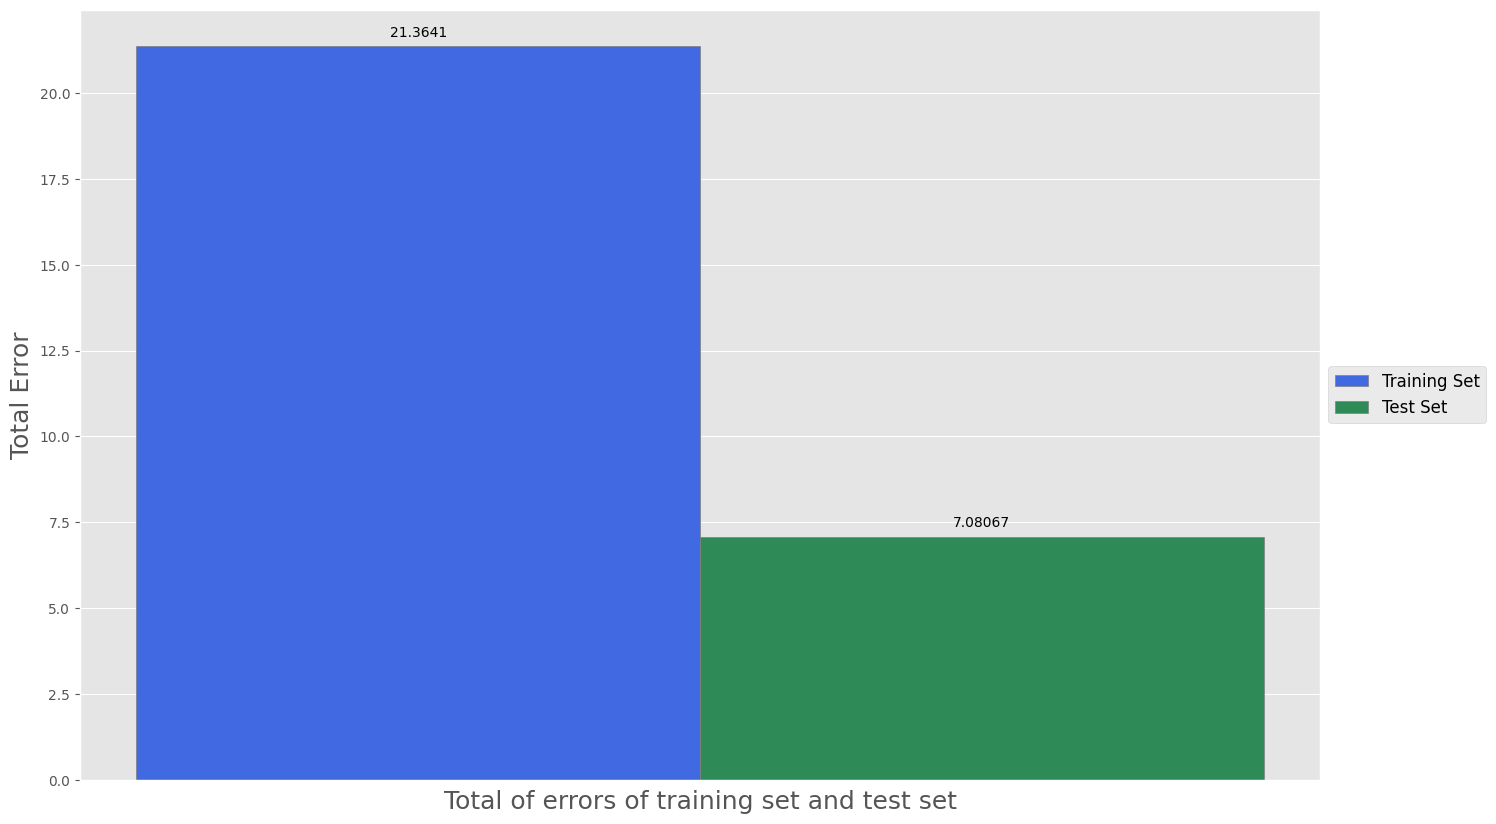

In [148]:
train_set = tuple([total_train_error])
test_set = tuple([total_test_error])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in range(10)]

rect1 = ax.bar(1-0.5, train_set, width=0.5, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(1, test_set, width=0.5, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')

ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
ax.set_xticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Total of errors of training set and test set', fontsize=18)
plt.ylabel('Total Error', fontsize=18)
fig.savefig('../assets/total_loss.png')

### Average result:

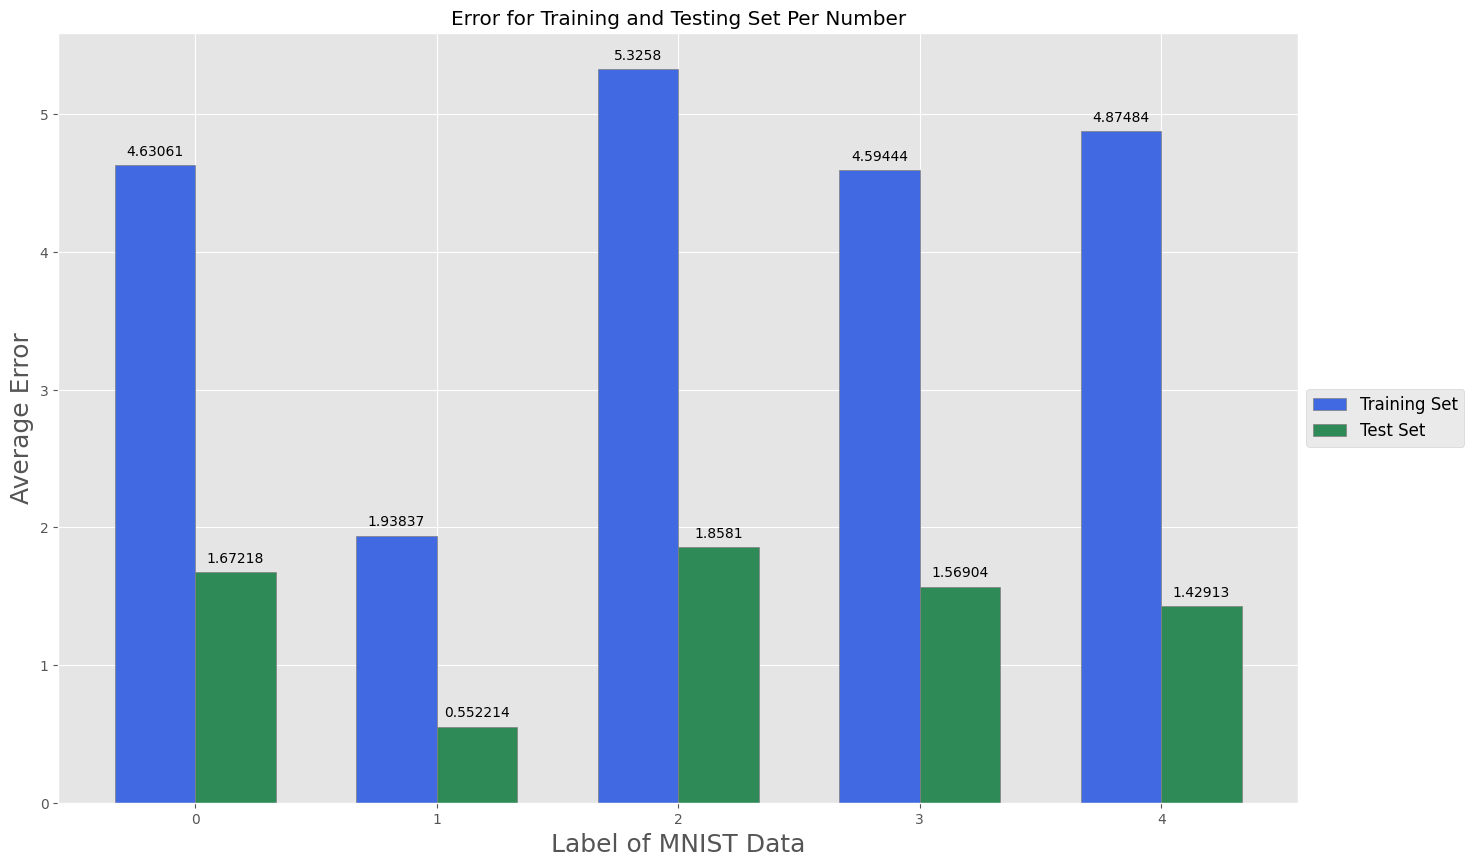

In [149]:
train_set = tuple(ERROR_TRAIN_1.values())
test_set = tuple(ERROR_TEST_1.values())
index = list(ERROR_TEST_1.keys())

width = np.min(np.diff(index)) / 3

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in index]

rect1 = ax.bar(index - width, train_set, width=width, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(index, test_set, width=width, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')
ax.set_xticks(index, labels)
ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Label of MNIST Data', fontsize=18)
plt.ylabel('Average Error', fontsize=18)
plt.title('Error for Training and Testing Set Per Number')
fig.savefig('../assets/average_loss_1.png')

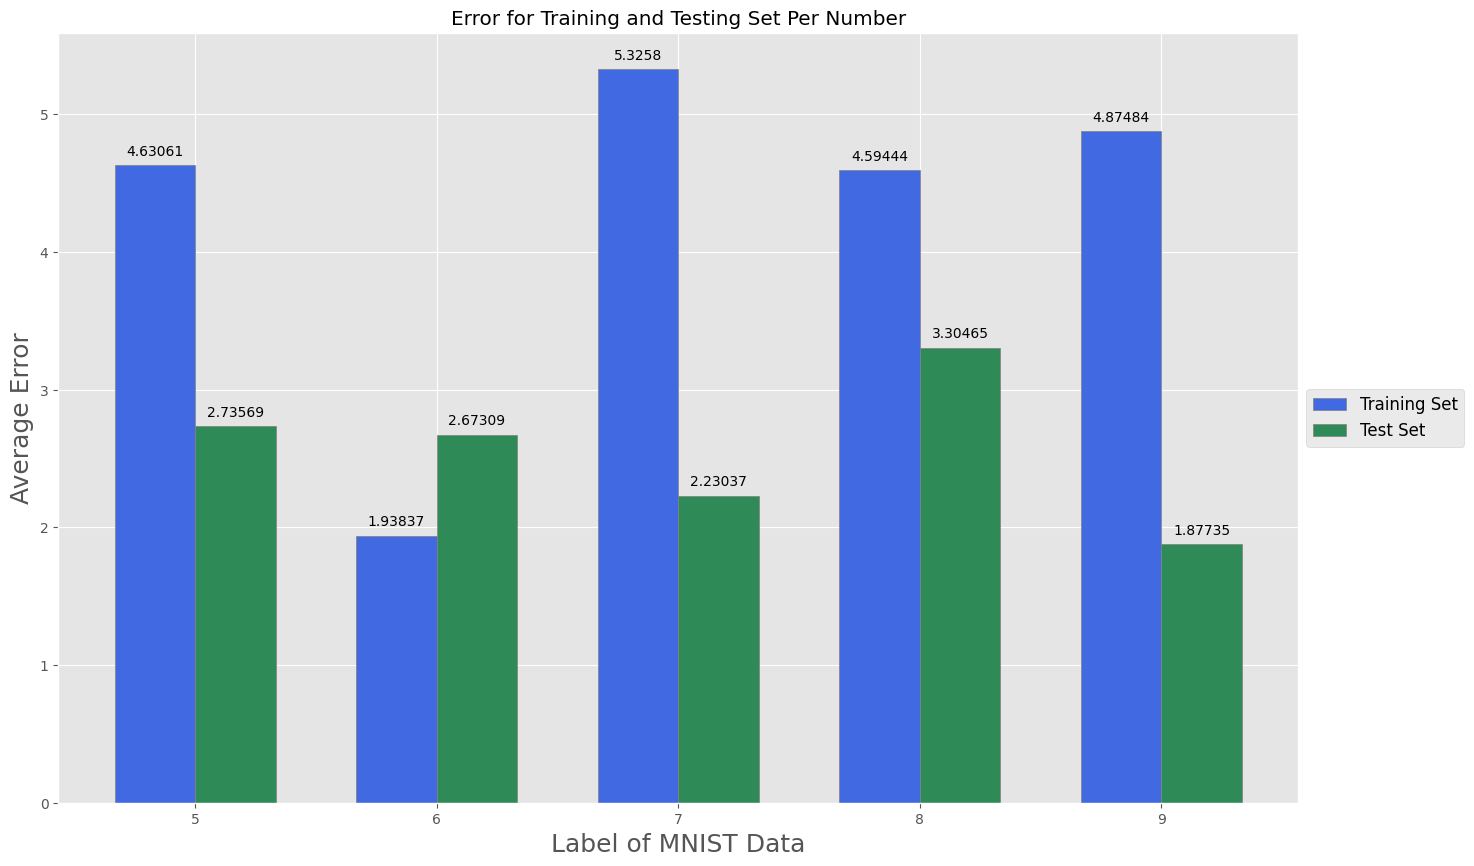

In [150]:
# train_set = tuple(ERROR_TRAIN_2.values())
test_set = tuple(ERROR_TEST_2.values())
index = list(ERROR_TEST_2.keys())

width = np.min(np.diff(index)) / 3

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in index]

rect1 = ax.bar(index - width, train_set, width=width, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(index, test_set, width=width, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')
ax.set_xticks(index, labels)
ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Label of MNIST Data', fontsize=18)
plt.ylabel('Average Error', fontsize=18)
plt.title('Error for Training and Testing Set Per Number')
fig.savefig('../assets/average_loss_2.png')